In [70]:
# import libraries needed
from pathlib import Path
import os, yaml, time, sys
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy import fft
#from .utils import *
# load in data
file_name = '../../Data/CubicBox_(-250.0, 250.0)_(-250.0, 250.0)_(-250.0, 250.0).npz'
particle_subsample = np.load(file_name)
x, y, z = particle_subsample['x'], particle_subsample['y'], particle_subsample['z']
vx, vy, vz = particle_subsample['vx'], particle_subsample['vy'], particle_subsample['vz'] 
x_range,y_range,z_range=[min(x),max(x)],[min(y),max(y)],[min(z),max(z)]

In [5]:
# split the data into the correct boxes
def full_density_histogram(grid,x=x,y=y,z=z):
    combined=np.column_stack((x,y,z))
    hist, edges = np.histogramdd(combined, bins=[grid,grid,grid])
    return hist, edges

In [6]:
# produce just a simple density plot
def density_plot(z1,grid,x_range=x_range,y_range=y_range):
    bins=int(500/grid)
    hist,edges=full_density_histogram(bins)
    z_bin = np.where((edges[2][:-1] >= z1) & (edges[2][:-1] < z1+grid))[0]
    slicey=hist[:,:,z_bin[0]]
    plt.imshow(slicey, extent=[x_range[0], x_range[1], y_range[0], y_range[1]], cmap='viridis')
    plt.xlabel('x coords')
    plt.ylabel('y coords')
    plt.colorbar(label='Number of particles')
    path = '../Figures/Density plot along z=({:.0f},{:.0f}) (gridsize of {:.0f} mpc cubed).png'.format(z1,z1+grid,grid)
    plt.savefig(path, dpi=300)
    plt.close()
    return

In [7]:
# produce a histogram of the densities in a particular slice
def histogram2d(z1,grid):
    bins=int(500/grid)
    hist,edges=full_density_histogram(bins)
    z_bin = np.where((edges[2][:-1] >= z1) & (edges[2][:-1] < z1+grid))[0]
    slicey=hist[:,:,z_bin[0]]
    slicey=slicey.flatten()
    plt.hist(np.log10(slicey+1),bins=25)
    plt.xlabel('Log10 density')
    plt.ylabel('Frequency')
    path = '../Figures/Histogram of densities along z=({:.0f},{:.0f}) (gridsize of {:.0f} mpc cubed).png'.format(z1,z1+grid,grid)
    plt.savefig(path, dpi=300)
    plt.close()
    return

In [8]:
# produce just a simple overdensity plot
def overdensity_plot(z1,grid,x_range=x_range,y_range=y_range,x=x):
    fullhist,ed=full_density_histogram(int(500/grid))
    smolboxvol=grid**3
    densities=fullhist/smolboxvol
    otherav=len(x)/(500**3)
    overdense=densities/otherav
    z_bin = np.where((ed[2][:-1] >= z1) & (ed[2][:-1] < z1+grid))[0]
    slices=overdense[:,:,z_bin[0]]
    plt.imshow(np.log10(slices), extent=[x_range[0], x_range[1], y_range[0], y_range[1]], cmap='viridis')
    plt.colorbar(label='$\log_{10}(\delta+1)$')
    plt.xlabel('x coords')
    plt.ylabel('y coords')
    path = '../Figures/Overdensities along z=({:.0f},{:.0f}) (gridsize of {:.0f} mpc cubed).png'.format(z1,z1+grid,grid)
    plt.savefig(path, dpi=300)
    plt.close()
    return

<>:11: SyntaxWarning: invalid escape sequence '\l'
<>:11: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_1474/2930326021.py:11: SyntaxWarning: invalid escape sequence '\l'
  plt.colorbar(label='$\log_{10}(\delta+1)$')


In [9]:
# produce the full 3D overdensity field
def overdensity_field(grid,x=x):
    fullhist,ed=full_density_histogram(int(500/grid))
    smolboxvol=grid**3
    densities=fullhist/smolboxvol
    otherav=len(x)/(500**3)
    overdense=densities/otherav-1
    return overdense, ed

In [10]:
# produce density plot with velocities overlayed
def density_with_velocities(z1,grid,x_range=x_range,y_range=y_range,vy=vy,vx=vx,x=x,y=y,z=z):
    bins=int(500/grid)
    hist,edges=full_density_histogram(bins)
    z_bin = np.where((edges[2][:-1] >= z1) & (edges[2][:-1] < z1+grid))[0]
    slicey=hist[:,:,z_bin[0]]
    velocitymask=(z<z1+grid)&(z>=z1)
    posx=x[velocitymask]
    posy=y[velocitymask]
    xvelo=vx[velocitymask]
    yvelo=vy[velocitymask]
    x_indices=np.digitize(posx,edges[0])-1
    y_indices=np.digitize(posy,edges[1])-1
    xidx = np.clip(x_indices, 0, bins-1)
    yidx = np.clip(y_indices, 0, bins-1)
    directx=np.zeros((bins,bins))
    directy=np.zeros((bins,bins))
    counts=np.zeros((bins,bins))
    np.add.at(directx, (xidx, yidx), xvelo)
    np.add.at(directy, (xidx, yidx), yvelo)
    np.add.at(counts, (xidx, yidx), 1)
    directx[counts > 0] /= counts[counts > 0]
    directy[counts > 0] /= counts[counts > 0]
    checkerx=directx.T.flatten()
    checkery=directy.T.flatten()
    oo=np.array(list(np.linspace(x_range[0]+5,x_range[1]-5,bins))*bins)
    oo=np.sort(oo)
    ee=np.array(list(np.linspace(y_range[0]+5,y_range[1]-5,bins))*bins)
    plt.quiver(oo,ee,checkerx,checkery,scale_units='xy',angles='xy', color='r',label='x-y velocities (km/s)')
    plt.xlabel('x coords')
    plt.ylabel('y coords')
    plt.legend(loc=2)
    plt.imshow(slicey, extent=[x_range[0], x_range[1], y_range[0], y_range[1]], cmap='viridis')
    plt.colorbar(label='Number of particles')
    path = '../Figures/Velocity density plot along z=({:.0f},{:.0f}) (gridsize of {:.0f} mpc cubed).png'.format(z1,z1+grid,grid)
    plt.savefig(path, dpi=300)
    plt.close()
    return    

In [11]:
# produce overdensity plot with velocities overlayed
def overdensity_with_velocities(z1,grid,x_range=x_range,y_range=y_range,vy=vy,vx=vx,x=x,y=y,z=z):
    smolboxvol=grid**3
    bins=int(500/grid)
    hist,edges=full_density_histogram(bins)
    densities=hist/smolboxvol
    otherav=len(x)/(500**3)
    overdense=densities/otherav
    z_bin = np.where((edges[2][:-1] >= z1) & (edges[2][:-1] < z1+grid))[0]
    slices=overdense[:,:,z_bin[0]]
    velocitymask=(z<z1+grid)&(z>=z1)
    posx=x[velocitymask]
    posy=y[velocitymask]
    xvelo=vx[velocitymask]
    yvelo=vy[velocitymask]
    x_indices=np.digitize(posx,edges[0])-1
    y_indices=np.digitize(posy,edges[1])-1
    xidx = np.clip(x_indices, 0, bins-1)
    yidx = np.clip(y_indices, 0, bins-1)
    directx=np.zeros((bins,bins))
    directy=np.zeros((bins,bins))
    counts=np.zeros((bins,bins))
    np.add.at(directx, (xidx, yidx), xvelo)
    np.add.at(directy, (xidx, yidx), yvelo)
    np.add.at(counts, (xidx, yidx), 1)
    directx[counts > 0] /= counts[counts > 0]
    directy[counts > 0] /= counts[counts > 0]
    checkerx=directx.flatten()
    checkery=directy.flatten()
    oo=np.array(list(np.linspace(x_range[0]+5,x_range[1]-5,bins))*bins)
    oo=np.sort(oo)
    ee=np.array(list(np.linspace(y_range[0]+5,y_range[1]-5,bins))*bins)
    plt.imshow(np.log10(slices), extent=[x_range[0], x_range[1], y_range[0], y_range[1]], cmap='viridis')
    plt.colorbar(label='$\log_{10}(\delta+1)$')
    plt.quiver(oo,ee,checkerx,checkery,scale_units='xy',angles='xy', color='r',label='x-y velocities (km/s)')
    plt.xlabel('x coords')
    plt.ylabel('y coords')
    plt.legend(loc=2)
    path = '../Figures/Velocity density plot along z=({:.0f},{:.0f}) (gridsize of {:.0f} mpc cubed).png'.format(z1,z1+grid,grid)
    plt.savefig(path, dpi=300)
    plt.close()
    return    

<>:34: SyntaxWarning: invalid escape sequence '\l'
<>:34: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_1474/4233418728.py:34: SyntaxWarning: invalid escape sequence '\l'
  plt.colorbar(label='$\log_{10}(\delta+1)$')


In [71]:
# calculate the mean and std of each box
# function can be varied to return component means and stds
def meanvelo_std(grid,x=x,y=y,z=z,vx=vx,vy=vy,vz=vz):
    bins=int(500/grid)
    hist,edges=full_density_histogram(bins)
    x_indices=np.digitize(x,edges[0])-1
    y_indices=np.digitize(y,edges[1])-1
    z_indices=np.digitize(z,edges[1])-1
    xidx = np.clip(x_indices, 0, bins-1)
    yidx = np.clip(y_indices, 0, bins-1)
    zidx = np.clip(z_indices, 0, bins-1)
    directx=np.zeros((bins,bins,bins))
    directy=np.zeros((bins,bins,bins))
    directz=np.zeros((bins,bins,bins))
    stdxsq=np.zeros((bins,bins,bins))
    stdysq=np.zeros((bins,bins,bins))
    stdzsq=np.zeros((bins,bins,bins))
    stdx=np.zeros((bins,bins,bins))
    stdy=np.zeros((bins,bins,bins))
    stdz=np.zeros((bins,bins,bins))
    counts=np.zeros((bins,bins,bins))
    np.add.at(directx, (xidx, yidx, zidx), vx)
    np.add.at(directy, (xidx, yidx, zidx), vy)
    np.add.at(directz, (xidx, yidx, zidx), vz)
    np.add.at(counts, (xidx, yidx, zidx), 1)
    directx[counts > 0] /= counts[counts > 0]
    directy[counts > 0] /= counts[counts > 0]
    directz[counts > 0] /= counts[counts > 0]
    np.add.at(stdxsq, (xidx, yidx, zidx), (vx-directx[xidx,yidx,zidx])**2)
    np.add.at(stdysq, (xidx, yidx, zidx), (vy-directx[xidx,yidx,zidx])**2)
    np.add.at(stdzsq, (xidx, yidx, zidx), (vz-directx[xidx,yidx,zidx])**2)
    stdx[counts > 0] = np.sqrt(stdxsq[counts > 0] / counts[counts>0])
    stdy[counts > 0] = np.sqrt(stdysq[counts > 0] / counts[counts>0])
    stdz[counts > 0] = np.sqrt(stdzsq[counts > 0] / counts[counts>0])
    stdt=np.sqrt((stdx**2+stdy**2+stdz**2)/3) # technically an rms
    means=np.sqrt(directx**2+directy**2+directz**2)
    return means, stdt, directx, directy, directz

In [21]:
# produce histogram of all velocity and std data
def produce_velo_std_histogram(grid):
    means,stdt,ex1,ex2,ex3=meanvelo_std(grid)
    plt.hist(means.flatten(),bins=25)
    plt.xlabel('Mean velocity (km/s)')
    plt.ylabel('Frequency')
    path = '../Figures/Histogram of all velocities (gridsize of {:.0f} mpc cubed).png'.format(grid)
    plt.savefig(path, dpi=300)
    plt.close()
    plt.hist(stdt.flatten(),bins=25)
    plt.xlabel('Velocity $\sigma$ (km/s)')
    plt.ylabel('Frequency')
    path='../Figures/Histogram of standard deviations in all velocities (gridsize of {:.0f} mpc cubed).png'.format(grid)
    plt.savefig(path, dpi=300)
    plt.close()
    return

<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1474/2575867609.py:11: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('Velocity $\sigma$ (km/s)')


In [14]:
# choose gridsize and slice to be investigated
gridsize=10
zlim=150

In [85]:
# calling each of the functions
histogram2d(zlim,gridsize)
density_plot(zlim,gridsize)
overdensity_plot(zlim,gridsize)
overdensity_field(gridsize)
density_with_velocities(zlim,gridsize)
overdensity_with_velocities(zlim,gridsize)
produce_velo_std_histogram(gridsize)

In [24]:
# rianna's code
# computes the density field
def compute_density_field(data, grid_size=None, n_grid=None, sample_fraction = 0.021):
    """
    A function that computes the density fluctuation field given the particle subsample for a cubic box

    :param data:        The (x, y, z) coords of the particles in the subsample (N x 3 numpy array)
    :param grid_size:   The size of the 3D grid cells in Mpc (OPTIONAL)
    :param n_grid:      The number of grid cells in 1 dimension such that n_total = n_grid^3 (OPTIONAL)
    """
    if grid_size is None and n_grid is None:
        raise NameError("Either the grid size or the number of grid cells must be specified")
    # compute the box dimensions
    box_lengths = [np.round((np.max(data[:, i]) - np.min(data[:, i]))) for i in range(np.shape(data)[1])]
    if box_lengths.count(box_lengths[0]) != len(box_lengths):
        raise RuntimeError("Input data is not a cubic box. All three side lengths must be equal. Currently (Lx, Ly, "
                           "Lz) = {}".format(box_lengths))
    # set the side length of the grid
    L = int(box_lengths[0])
    # compute the number of grid cells (if the grid size is provided)
    if grid_size is not None:
        ngrid = 500 / grid_size
        if not ngrid.is_integer():
            raise TypeError("Grid spacing is not compatible with the dimension of the simulation. Box size = {} and "
                            "Grid size = {}".format(L, grid_size))
        if n_grid is not None:
            raise NameError(
                "The grid size and the number of cells cannot be specified at the same time. Please specify only one "
                "of these variables.")
    else:
        ngrid = int(n_grid)
        grid_size = L / ngrid
    print('Computing the matter density field, with a grid size of {} Mpc...'.format(grid_size))
    # get an array of the bin edges for the grid 
    edge_array = np.linspace(-L / 2, L/2, int(ngrid + 1))
    # get a tuple of the bin edges for the histogram
    bin_edges = tuple([edge_array for _ in range(np.shape(data)[1])])
    # compute the density in each grid cell 
    density, _ = np.histogramdd(data, bins=bin_edges)
    return density, edge_array

In [25]:
# rianna's code
# computes the density fluctation field
def compute_density_fluctuation_field(data, grid_size=None, n_grid=None, edge_array=None, sample_fraction=0.021):
    """
    A function that computes the density fluctuation field given the particle subsample for a cubic box

    :param data:        Either the (x, y, z) coords of the particles in the subsample (N x 3 numpy array) or the gridded density field (N x N x N numpy array)
    :param grid_size:   The size of the 3D grid cells in Mpc (OPTIONAL)
    :param n_grid:      The number of grid cells in 1 dimension such that n_total = n_grid^3 (OPTIONAL)
    """
    # compute the input data shape 
    data_shape = np.array(data.shape)
    # if the data is a set of (x, y, z) coords compute the matter density field first
    if (data_shape != data_shape[0]).any():
        density_field, edges = compute_density_field(data=data, grid_size=grid_size, n_grid=n_grid, sample_fraction=sample_fraction)
    else: 
        edges = edge_array
        density_field = data
    if grid_size is None:
        grid_size = edges[1] - edges[0]
    print('Computing the matter density fluctuation field...')
    # compute the average particle density in the cubic box
    p_avg = (6912 ** 3) / (2000 ** 3)
    # compute the normalised density field in the cubic box
    p_box = (density_field / sample_fraction) / (grid_size ** len(density_field.shape))
    # compute the matter density fluctuation field
    delta = p_box / p_avg - 1
    return delta, edges

In [26]:
# rianna's code
# called in the function below for the velocity field
def wave_num(kgrid):
    """
    A function that computes the magnitude of the angular wave number k from it's cartesian components on a grid
    :param kgrid: The k-space meshgrid
    """
    kx, ky = kgrid[0], kgrid[1]
    kz = np.zeros_like(kx) if len(kgrid)==2 else kgrid[2]
    return 2 * np.pi * np.sqrt(kx ** 2 + ky ** 2 + kz ** 2)

In [27]:
# rianna's code
# called in the function below for the velocity field
def get_velocity_grids(field, edges):
    """
    A function that returns the grid over which the velocity field will be computed in both real and fourier 
    space. 
    :param field:    The grid corresponding to the matter density field (2D or 3D)
    :param edges:    The side-length of the grid cells used to compute the velocity field.
    """
    # compute the number of dimensions of the density_field 
    N = len(np.shape(field))
    if N not in [2, 3]: 
        raise ValueError("Density field does not appear to be either a 2D or 3D field. The density field has a shape {}".format(np.shape(density_field))) 
    # compute the side length of the density field (in Mpc) 
    L = np.max(edges) - np.min(edges)
    ngrid = len(edges) - 1
    kgrid_arrays = [np.fft.fftfreq(ngrid, L / (ngrid-1)) for _ in range(N-1)]
    kgrid_arrays.extend([np.fft.rfftfreq(ngrid, L / (ngrid-1))])
    # generate the fourier-space velocity grid
    kgrid = np.meshgrid(*reversed(kgrid_arrays)) if N==2 else np.meshgrid(*kgrid_arrays)
    return kgrid

In [28]:
# rianna's code
# computes lin velocity field
def compute_velocity_field(delta, grid_edges, H0=67, omega_m=0.3):
    """
    A function that computes the linear peculiar velocity field across a grid, using a set cosmology
    and a given matter density field.
    :param delta:   The input matter density field (2D or 3D)
    :param grid_edges:    The edges of the bins used to compude the density field (1D array)
    :param H0:              The hubble constant used in the velocity field computation (default is 67
                            km/s/Mpc from Plank2018)
    :param omega_m:         The cosmological matter density parameter used in the velocity field 
                            computation (default is 0.3 from Plank2018)
    """
    print('Computing the linear velocity field...')
    # compute f
    f = omega_m ** 0.6
    # compute the number of dimensions of the density field 
    N = len(np.shape(delta))
    # compute the real space and fourier space grids needed to compute the velocity field.
    k_grid = get_velocity_grids(delta, grid_edges)
    # # compute the wavenumber at each grid point
    k = wave_num(k_grid)
    # compute the k-space density field
    delta_k = fft.rfftn(delta)
    # initialise the fourier space velocity array
    velocity_kx = np.zeros_like(delta_k)
    velocity_ky = np.zeros_like(delta_k)
    velocity_kz = np.zeros_like(delta_k)
    # create the mask for the non-zero wavenumbers
    mask = k != 0
    velocity_kx[mask] = 1j * f * H0 * delta_k[mask] * k_grid[0][mask] / k[mask] ** 2
    velocity_ky[mask] = 1j * f * H0 * delta_k[mask] * k_grid[1][mask] / k[mask] ** 2
    if N == 3: 
        velocity_kz[mask] = 1j * f * H0 * delta_k[mask] * k_grid[2][mask] / k[mask] ** 2
    # compute the inverse transformation to get the real space velocity field
    vx = np.fft.irfftn(velocity_ky, delta.shape)
    vy = np.fft.irfftn(velocity_kx, delta.shape)
    vz = np.fft.irfftn(velocity_kz, delta.shape) if N == 3 else np.zeros_like(vx)
    # return [v_grid[1].T, v_grid[0].T], vx.T, vy.T
    return [vx, vy, vz]

In [15]:
overdense,edie=overdensity_field(gridsize)

In [72]:
eek,ook,mx,my,mz=meanvelo_std(gridsize)

In [73]:
xvie,yvie,zvie=compute_velocity_field(overdense,edie[0])

Computing the linear velocity field...


201.17654469407117


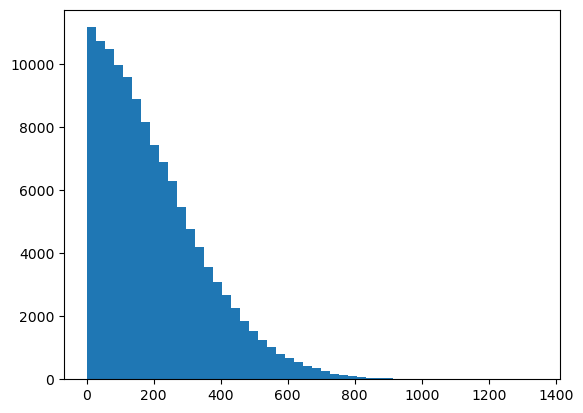

In [53]:
diffy=abs(mz-zvie) #something up with the scaling perhaps???
print(np.average(diffy.flatten()))
plt.hist(diffy.flatten(), bins=50);

/tmp/ipykernel_1474/3511191910.py:1: RuntimeWarning: invalid value encountered in log10
  plt.hist(np.log10(mz.flatten()),bins=50);
/tmp/ipykernel_1474/3511191910.py:2: RuntimeWarning: invalid value encountered in log10
  plt.hist(np.log10(zvie.flatten()),bins=50);


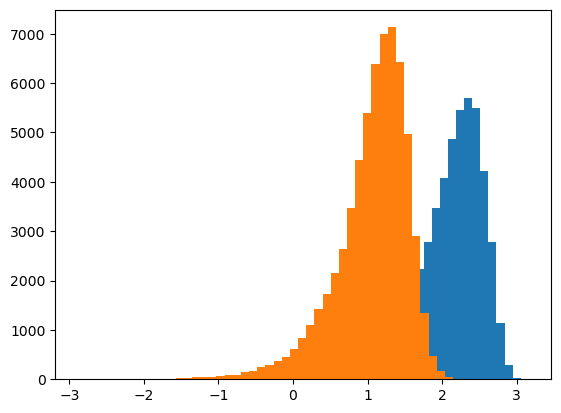

In [74]:
plt.hist(np.log10(mz.flatten()),bins=50);
plt.hist(np.log10(zvie.flatten()),bins=50);
# why does it look like this?? is smthn up with the scaling??
# like all three are like this???????

In [94]:
def plot_slice_reconstruct(xvelo,yvelo,z1,grid,x_range=x_range,y_range=y_range):
    bins=int(500/grid)
    overdensie,ed=overdensity_field(grid)
    overdensie+=1
    z_bin = np.where((ed[2][:-1] >= z1) & (ed[2][:-1] < z1+grid))[0]
    slices=overdensie[:,:,z_bin[0]]
    vxslices=xvelo[:,:,z_bin[0]]
    vyslices=yvelo[:,:,z_bin[0]]
    oo=np.array(list(np.linspace(x_range[0]+5,x_range[1]-5,bins))*bins)
    oo=np.sort(oo)
    ee=np.array(list(np.linspace(y_range[0]+5,y_range[1]-5,bins))*bins)
    plt.imshow(np.log10(slices), extent=[x_range[0], x_range[1], y_range[0], y_range[1]], cmap='viridis')
    plt.colorbar(label='$\log_{10}(\delta+1)$')
    plt.quiver(oo,ee,vxslices,vyslices,scale_units='xy',angles='xy', color='r',label='x-y velocities (km/s)')
    plt.legend(loc=2)
    plt.xlabel('x coords')
    plt.ylabel('y coords')
    path = '../Figures/Reconstructed velocities along z=({:.0f},{:.0f}) (gridsize of {:.0f} mpc cubed).png'.format(z1,z1+grid,grid)
    plt.savefig(path, dpi=300)
    plt.close()
    return

<>:13: SyntaxWarning: invalid escape sequence '\l'
<>:13: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_987/3689846623.py:13: SyntaxWarning: invalid escape sequence '\l'
  plt.colorbar(label='$\log_{10}(\delta+1)$')


In [120]:
def comparison_pic(z1,grid,vvx,vvy,x_range=x_range,y_range=y_range,vy=vy,vx=vx,x=x,y=y,z=z):
    smolboxvol=grid**3
    bins=int(500/grid)
    hist,edges=full_density_histogram(bins)
    densities=hist/smolboxvol
    otherav=len(x)/(500**3)
    overdense=densities/otherav
    z_bin = np.where((edges[2][:-1] >= z1) & (edges[2][:-1] < z1+grid))[0]
    slices=overdense[:,:,z_bin[0]]
    velocitymask=(z<z1+grid)&(z>=z1)
    posx=x[velocitymask]
    posy=y[velocitymask]
    xvelo=vx[velocitymask]
    yvelo=vy[velocitymask]
    x_indices=np.digitize(posx,edges[0])-1
    y_indices=np.digitize(posy,edges[1])-1
    xidx = np.clip(x_indices, 0, bins-1)
    yidx = np.clip(y_indices, 0, bins-1)
    directx=np.zeros((bins,bins))
    directy=np.zeros((bins,bins))
    counts=np.zeros((bins,bins))
    np.add.at(directx, (xidx, yidx), xvelo)
    np.add.at(directy, (xidx, yidx), yvelo)
    np.add.at(counts, (xidx, yidx), 1)
    directx[counts > 0] /= counts[counts > 0]
    directy[counts > 0] /= counts[counts > 0]
    checkerx=directx.flatten()
    checkery=directy.flatten()
    oo=np.array(list(np.linspace(x_range[0]+5,x_range[1]-5,bins))*bins)
    oo=np.sort(oo)
    ee=np.array(list(np.linspace(y_range[0]+5,y_range[1]-5,bins))*bins)
    fig, axes = plt.subplots(1,2,figsize=(12,4))
    ax=axes[0]
    im=ax.imshow(np.log10(slices), extent=[x_range[0], x_range[1], y_range[0], y_range[1]], cmap='viridis')
    fig.colorbar(im, ax=ax, label='$\log_{10}(\delta+1)$')
    ax.quiver(oo,ee,checkerx,checkery,scale_units='xy',angles='xy', color='r',label='x-y velocities (km/s)')
    ax.set_xlabel('x coords')
    ax.set_ylabel('y coords')
    ax.legend(loc=2)
    ax.set_title('Actual velocities')

    bins=int(500/grid)
    overdensie,ed=overdensity_field(grid)
    overdensie+=1
    z_bin = np.where((ed[2][:-1] >= z1) & (ed[2][:-1] < z1+grid))[0]
    slices=overdensie[:,:,z_bin[0]]
    vxslices=vvx[:,:,z_bin[0]]
    vyslices=vvy[:,:,z_bin[0]]
    oo=np.array(list(np.linspace(x_range[0]+5,x_range[1]-5,bins))*bins)
    oo=np.sort(oo)
    ee=np.array(list(np.linspace(y_range[0]+5,y_range[1]-5,bins))*bins)
    ax=axes[1]
    im=ax.imshow(np.log10(slices), extent=[x_range[0], x_range[1], y_range[0], y_range[1]], cmap='viridis')
    fig.colorbar(im, ax=ax, label='$\log_{10}(\delta+1)$')
    ax.quiver(oo,ee,vxslices,vyslices,scale_units='xy',angles='xy', color='r',label='x-y velocities (km/s)')
    ax.set_xlabel('x coords')
    ax.set_ylabel('y coords')
    ax.legend(loc=2)
    ax.set_title('Reconstructed velocities')

    path = '../Figures/Reconstructed vs actual velocities along z=({:.0f},{:.0f}) (gridsize of {:.0f} mpc cubed).png'.format(z1,z1+grid,grid)
    plt.savefig(path, dpi=300)
    plt.close()
    return    

<>:35: SyntaxWarning: invalid escape sequence '\l'
<>:54: SyntaxWarning: invalid escape sequence '\l'
<>:35: SyntaxWarning: invalid escape sequence '\l'
<>:54: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_987/1739045779.py:35: SyntaxWarning: invalid escape sequence '\l'
  fig.colorbar(im, ax=ax, label='$\log_{10}(\delta+1)$')
/tmp/ipykernel_987/1739045779.py:54: SyntaxWarning: invalid escape sequence '\l'
  fig.colorbar(im, ax=ax, label='$\log_{10}(\delta+1)$')


In [67]:
def overlay_pic(z1,grid,vvx,vvy,x_range=x_range,y_range=y_range,vy=vy,vx=vx,x=x,y=y,z=z):
    smolboxvol=grid**3
    bins=int(500/grid)
    hist,edges=full_density_histogram(bins)
    densities=hist/smolboxvol
    otherav=len(x)/(500**3)
    overdense=densities/otherav
    z_bin = np.where((edges[2][:-1] >= z1) & (edges[2][:-1] < z1+grid))[0]
    slices=overdense[:,:,z_bin[0]]
    velocitymask=(z<z1+grid)&(z>=z1)
    posx=x[velocitymask]
    posy=y[velocitymask]
    xvelo=vx[velocitymask]
    yvelo=vy[velocitymask]
    x_indices=np.digitize(posx,edges[0])-1
    y_indices=np.digitize(posy,edges[1])-1
    xidx = np.clip(x_indices, 0, bins-1)
    yidx = np.clip(y_indices, 0, bins-1)
    directx=np.zeros((bins,bins))
    directy=np.zeros((bins,bins))
    counts=np.zeros((bins,bins))
    np.add.at(directx, (xidx, yidx), xvelo)
    np.add.at(directy, (xidx, yidx), yvelo)
    np.add.at(counts, (xidx, yidx), 1)
    directx[counts > 0] /= counts[counts > 0]
    directy[counts > 0] /= counts[counts > 0]
    checkerx=directx.flatten()
    checkery=directy.flatten()
    oo=np.array(list(np.linspace(x_range[0]+5,x_range[1]-5,bins))*bins)
    oo=np.sort(oo)
    ee=np.array(list(np.linspace(y_range[0]+5,y_range[1]-5,bins))*bins)
    overdensie,ed=overdensity_field(grid)
    overdensie+=1
    z_bin = np.where((ed[2][:-1] >= z1) & (ed[2][:-1] < z1+grid))[0]
    slices=overdensie[:,:,z_bin[0]]
    vxslices=vvx[:,:,z_bin[0]]
    vyslices=vvy[:,:,z_bin[0]]
    print(max(vxslices.flatten()),max(checkerx.flatten()))
    ooi=np.array(list(np.linspace(x_range[0]+5,x_range[1]-5,bins))*bins)
    ooi=np.sort(ooi)
    eei=np.array(list(np.linspace(y_range[0]+5,y_range[1]-5,bins))*bins)
    plt.imshow(np.log10(slices), extent=[x_range[0], x_range[1], y_range[0], y_range[1]], cmap='Greys')
    plt.colorbar(label='$\log_{10}(\delta+1)$')
    plt.quiver(oo,ee,checkerx,checkery,scale_units='xy',angles='xy', color='r',label='Actual velocities (km/s)')
    plt.quiver(ooi,eei,vxslices,vyslices,scale_units='xy',angles='xy', color='b',label='Reconstructed velocities (km/s)')
    plt.xlabel('x coords')
    plt.ylabel('y coords')
    plt.legend(loc=2)

    path = '../Figures/Reconstructed vs actual velocities (overlayed) along z=({:.0f},{:.0f}) (gridsize of {:.0f} mpc cubed).png'.format(z1,z1+grid,grid)
    plt.savefig(path, dpi=300)
    plt.close()
    return    

<>:43: SyntaxWarning: invalid escape sequence '\l'
<>:43: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_1474/2101299135.py:43: SyntaxWarning: invalid escape sequence '\l'
  plt.colorbar(label='$\log_{10}(\delta+1)$')


In [113]:
comparison_pic(zlim,gridsize,xvie,yvie)

In [95]:
plot_slice_reconstruct(xvie,yvie,zlim,gridsize)

In [ ]:
# THE FOLLOWING CODE ISN'T GREAT AND THUS ISN'T IN USE

In [ ]:
# NOT IN USE
# Plotting velocities
vx_dist, edgesvx = np.histogram(vx, bins=20)
vy_dist, edgesvy = np.histogram(vy, bins=20)
vz_dist, edgesvz = np.histogram(vz, bins=20)
centresvx = edgesvx[:-1] + (edgesvx[1] - edgesvx[0])/2
centresvy = edgesvy[:-1] + (edgesvy[1] - edgesvy[0])/2
centresvz = edgesvz[:-1] + (edgesvz[1] - edgesvz[0])/2
widthvx = (edgesvx[1] - edgesvx[0]) * 0.95
widthvy = (edgesvy[1] - edgesvy[0]) * 0.95
widthvz = (edgesvz[1] - edgesvz[0]) * 0.95
plot_heightvx = max(np.log10(vx_dist))+0.1*max(np.log10(vx_dist))
plot_heightvy = max(np.log10(vy_dist))+0.1*max(np.log10(vy_dist))
plot_heightvz = max(np.log10(vz_dist))+0.1*max(np.log10(vz_dist))
fig, (axs1, axs2, axs3) = plt.subplots(1, 3, sharex=False, sharey=False, figsize=(18,6))
axs1.bar(centresvx, np.log10(vx_dist+1), width=widthvx, color='r', alpha=0.8, label='vx-coord distribution')
axs2.bar(centresvy, np.log10(vy_dist+1), width=widthvy, color='g', alpha=0.8, label='vy-coord distribution')
axs3.bar(centresvz, np.log10(vz_dist+1), width=widthvz, color='b', alpha=0.8, label='vz-coord distribution')
axs1.set_ylim([0, plot_heightvx])
axs2.set_ylim([0, plot_heightvy])
axs3.set_ylim([0, plot_heightvz])
axs1.legend(loc="upper left")
axs1.set_xlabel('vx (km/s)')
axs1.set_ylabel('log10 particle count')
axs2.legend(loc="upper left")
axs2.set_xlabel('vy (km/s)')
axs2.set_ylabel('log10 particle count')
axs3.legend(loc="upper left")
axs3.set_xlabel('vz (km/s)')
axs3.set_ylabel('log10 particle count')
path = '../Figures/Particle velocity distribution along the axes.png'
plt.savefig(path, dpi=300)
plt.close()  

In [ ]:
# NOT IN USE
def create_mask(x_start, y_start, z_start, size, x=x, y=y, z=z):
    newmask=(x>=x_start)&(x<x_start+size)&(y>=y_start)&(y<y_start+size)&(z>=z_start)&(z<z_start+size)
    newx=x[newmask]
    newy=y[newmask]
    newz=z[newmask]
    newvx=vx[newmask]
    newvy=vy[newmask]
    newvz=vz[newmask]
    return newx,newy,newz,newvx,newvy,newvz

In [ ]:
# NOT IN USE
def create_2d_density_plot(x_data,y_data,x_start,y_start,z_start,size,bins):
    histdata, xed, yed, colours = plt.hist2d(x_data,y_data,bins=bins)
    cbar = plt.colorbar(colours)
    cbar.set_label('Density')
    plt.xlabel('x coords')
    plt.ylabel('y coords')
    path = '../Figures/Density plot of size {:.0e} mpc cubed from x=({:.0f},{:.0f}), y=({:.0f},{:.0f}), z=({:.0f},{:.0f}).png'.format(size**3,x_start,x_start+size,y_start,y_start+size,z_start,z_start+size)
    plt.savefig(path, dpi=300)
    plt.close()
    return histdata

In [ ]:
# NOT IN USE
def create_3d_vector_plot(x_data,y_data,z_data,vx_data,vy_data,vz_data,x_start,y_start,z_start,size,sample):
    ax=plt.figure().add_subplot(111,projection='3d')
    ax.scatter(x_data[::sample],y_data[::sample],z_data[::sample],color='k')
    ax.quiver(x_data[::sample],y_data[::sample],z_data[::sample],vx_data[::sample],vy_data[::sample],vz_data[::sample],length=0.002,color='r',alpha=0.5)
    ax.set_xlabel('x coords')
    ax.set_ylabel('y coords')
    ax.set_zlabel('z coords')
    path = '../Figures/Sample of every {:.0f} velocity vectors from x=({:.0f},{:.0f}), y=({:.0f},{:.0f}), z=({:.0f},{:.0f}) for box {}.png'.format(sample, x_start,x_start+size,y_start,y_start+size,z_start,z_start+size,box_ID)
    plt.savefig(path, dpi=300)
    plt.close()
    return

In [ ]:
# NOT IN USE
def create_histogram(histdata,bins,x_start,y_start,z_start,size):
    plt.hist(np.log10(histdata+1),bins=bins)
    plt.xlabel('Log10 density')
    plt.ylabel('Frequency')
    path = '../Figures/Histogram of density plot from x=({:.0f},{:.0f}), y=({:.0f},{:.0f}), z=({:.0f},{:.0f}).png'.format(x_start,x_start+size,y_start,y_start+size,z_start,z_start+size)
    plt.savefig(path, dpi=300)
    plt.close()
    return